## Generative Adversarial Network

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
print(device)

cuda


<Axes: xlabel='Date'>

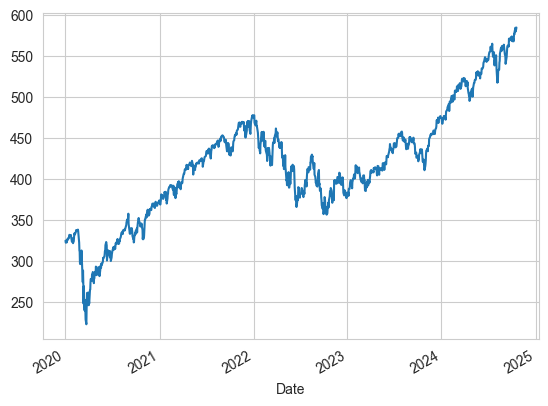

In [109]:
data = yf.download('SPY', start = '2020-01-01', end = pd.to_datetime('today'), progress = False)
data['Close'].plot()

In [110]:
def timegan(ori_data, parameters):
    """
    TimeGAN function.

    Use original data as training set to generate synthetic time-series data.

    Args:
        - ori_data: original time-series data
        - parameters: TimeGAN network parameters

    Returns:
        - generated_data: generated time-series data
    """
    # Basic Parameters
    no, seq_len, dim = np.asarray(ori_data).shape

    # Maximum sequence length and each sequence length
    ori_time, max_seq_len = extract_time(ori_data)

    # Normalization
    ori_data, min_val, max_val = MinMaxScaler(ori_data)

    # Network Parameters
    hidden_dim = parameters['hidden_dim'] 
    num_layers = parameters['num_layer']
    iterations = parameters['iterations']
    batch_size = parameters['batch_size']
    module_name = parameters['module'] 
    z_dim = dim
    gamma = 1

    # Define networks
    embedder = Embedder(module_name, dim, hidden_dim, num_layers)
    recovery = Recovery(module_name, hidden_dim, dim, num_layers)
    generator = Generator(module_name, z_dim, hidden_dim, num_layers)
    supervisor = Supervisor(module_name, hidden_dim, num_layers)
    discriminator = Discriminator(module_name, hidden_dim, num_layers)

    # Optimizers
    e_params = list(embedder.parameters()) + list(recovery.parameters())
    g_params = list(generator.parameters()) + list(supervisor.parameters())
    d_params = list(discriminator.parameters())

    E0_solver = optim.Adam(e_params)
    E_solver = optim.Adam(e_params)
    D_solver = optim.Adam(d_params)
    G_solver = optim.Adam(g_params)
    GS_solver = optim.Adam(g_params)

    # Loss functions
    bce_loss = nn.BCEWithLogitsLoss()
    mse_loss = nn.MSELoss()

    # Start training

    # 1. Embedding network training
    print('Start Embedding Network Training')

    for itt in range(iterations):
        # Set mini-batch
        X_mb, T_mb = batch_generator(ori_data, ori_time, batch_size)
        # Convert X_mb and T_mb to tensors
        X_mb_padded, T_mb = pad_sequences(X_mb, T_mb, max_seq_len)
        X_mb_padded = torch.tensor(X_mb_padded, dtype=torch.float32)

        # Forward pass
        H = embedder(X_mb_padded, T_mb)
        X_tilde = recovery(H, T_mb)

        # Compute loss
        E_loss_T0 = mse_loss(X_mb_padded, X_tilde)
        E_loss0 = 10 * torch.sqrt(E_loss_T0)

        # Backward and optimize
        E0_solver.zero_grad()
        E_loss0.backward()
        E0_solver.step()

        # Checkpoint
        if itt % 1000 == 0:
            print('step: '+ str(itt) + '/' + str(iterations) + ', e_loss: ' + str(np.round(np.sqrt(E_loss_T0.item()),4)) ) 

    print('Finish Embedding Network Training')

    # 2. Training only with supervised loss
    print('Start Training with Supervised Loss Only')

    for itt in range(iterations):
        # Set mini-batch
        X_mb, T_mb = batch_generator(ori_data, ori_time, batch_size)
        X_mb_padded, T_mb = pad_sequences(X_mb, T_mb, max_seq_len)
        X_mb_padded = torch.tensor(X_mb_padded, dtype=torch.float32)

        # Forward pass
        H = embedder(X_mb_padded, T_mb)
        H_hat_supervise = supervisor(H, T_mb)

        G_loss_S = mse_loss(H[:,1:,:], H_hat_supervise[:,:-1,:])

        # Backward and optimize
        GS_solver.zero_grad()
        G_loss_S.backward()
        GS_solver.step()

        # Checkpoint
        if itt % 1000 == 0:
            print('step: '+ str(itt)  + '/' + str(iterations) +', s_loss: ' + str(np.round(np.sqrt(G_loss_S.item()),4)) )

    print('Finish Training with Supervised Loss Only')

    # 3. Joint Training
    print('Start Joint Training')

    for itt in range(iterations):
        # Generator training (twice more than discriminator training)
        for kk in range(2):
            # Set mini-batch
            X_mb, T_mb = batch_generator(ori_data, ori_time, batch_size)
            X_mb_padded, T_mb = pad_sequences(X_mb, T_mb, max_seq_len)
            X_mb_padded = torch.tensor(X_mb_padded, dtype=torch.float32)
    
            # Random vector generation
            Z_mb = random_generator(batch_size, z_dim, T_mb, max_seq_len)
            Z_mb_padded = torch.tensor(Z_mb, dtype=torch.float32)
    
            # Generator forward pass
            E_hat = generator(Z_mb_padded, T_mb)
            H_hat = supervisor(E_hat, T_mb)
            X_hat = recovery(H_hat, T_mb)
    
            # Discriminator forward pass
            Y_fake = discriminator(H_hat, T_mb)
            Y_fake_e = discriminator(E_hat, T_mb)
    
            # Real data
            H = embedder(X_mb_padded, T_mb)
            H_hat_supervise = supervisor(H, T_mb)
            Y_real = discriminator(H, T_mb)
    
            # Generator loss
            G_loss_U = bce_loss(Y_fake, torch.ones_like(Y_fake))
            G_loss_U_e = bce_loss(Y_fake_e, torch.ones_like(Y_fake_e))
            G_loss_S = mse_loss(H[:,1:,:], H_hat_supervise[:,:-1,:])
    
            # Two moments loss
            X_hat_mean = torch.mean(X_hat, dim=0)
            X_hat_std = torch.std(X_hat, dim=0)
            X_mb_mean = torch.mean(X_mb_padded, dim=0)
            X_mb_std = torch.std(X_mb_padded, dim=0)
    
            G_loss_V1 = torch.mean(torch.abs(X_hat_std - X_mb_std))
            G_loss_V2 = torch.mean(torch.abs(X_hat_mean - X_mb_mean))
            G_loss_V = G_loss_V1 + G_loss_V2
    
            G_loss = G_loss_U + gamma * G_loss_U_e + 100 * torch.sqrt(G_loss_S) + 100 * G_loss_V
    
            # Generator backward and optimize
            G_solver.zero_grad()
            G_loss.backward()
            G_solver.step()
    
            # Recompute for Embedder loss to avoid using the same graph
            H = embedder(X_mb_padded, T_mb)
            X_tilde = recovery(H, T_mb)
            E_loss_T0 = mse_loss(X_mb_padded, X_tilde)
            E_loss0 = 10 * torch.sqrt(E_loss_T0)
    
            # Recompute G_loss_S
            H_hat_supervise = supervisor(H, T_mb)
            G_loss_S = mse_loss(H[:,1:,:], H_hat_supervise[:,:-1,:])
    
            E_loss = E_loss0 + 0.1 * G_loss_S
    
            # Embedder backward and optimize
            E_solver.zero_grad()
            E_loss.backward()
            E_solver.step()

        # Discriminator training
        # Set mini-batch
        X_mb, T_mb = batch_generator(ori_data, ori_time, batch_size)
        X_mb_padded, T_mb = pad_sequences(X_mb, T_mb, max_seq_len)
        X_mb_padded = torch.tensor(X_mb_padded, dtype=torch.float32)

        # Random vector generation
        Z_mb = random_generator(batch_size, z_dim, T_mb, max_seq_len)
        Z_mb_padded = torch.tensor(Z_mb, dtype=torch.float32)

        # Forward pass
        H = embedder(X_mb_padded, T_mb)
        E_hat = generator(Z_mb_padded, T_mb)
        H_hat = supervisor(E_hat, T_mb)

        Y_real = discriminator(H, T_mb)
        Y_fake = discriminator(H_hat, T_mb)
        Y_fake_e = discriminator(E_hat, T_mb)

        # Discriminator loss
        D_loss_real = bce_loss(Y_real, torch.ones_like(Y_real))
        D_loss_fake = bce_loss(Y_fake, torch.zeros_like(Y_fake))
        D_loss_fake_e = bce_loss(Y_fake_e, torch.zeros_like(Y_fake_e))
        D_loss = D_loss_real + D_loss_fake + gamma * D_loss_fake_e

        # Check discriminator loss before updating
        if D_loss.item() > 0.15:
            # Backward and optimize
            D_solver.zero_grad()
            D_loss.backward()
            D_solver.step()

        # Print multiple checkpoints
        if itt % 1000 == 0:
            print('step: '+ str(itt) + '/' + str(iterations) + 
                  ', d_loss: ' + str(np.round(D_loss.item(),4)) + 
                  ', g_loss_u: ' + str(np.round(G_loss_U.item(),4)) + 
                  ', g_loss_s: ' + str(np.round(np.sqrt(G_loss_S.item()),4)) + 
                  ', g_loss_v: ' + str(np.round(G_loss_V.item(),4)) + 
                  ', e_loss_t0: ' + str(np.round(np.sqrt(E_loss_T0.item()),4))  )

    print('Finish Joint Training')

    # Synthetic data generation
    Z_mb = random_generator(no, z_dim, ori_time, max_seq_len)
    Z_mb_padded = torch.tensor(Z_mb, dtype=torch.float32)

    E_hat = generator(Z_mb_padded, ori_time)
    H_hat = supervisor(E_hat, ori_time)
    generated_data_curr = recovery(H_hat, ori_time)

    # Convert generated_data_curr to numpy and extract the sequences
    generated_data = []
    generated_data_curr = generated_data_curr.detach().numpy()
    for i in range(no):
        temp = generated_data_curr[i,:ori_time[i],:]
        generated_data.append(temp)

    # Renormalization
    generated_data = generated_data * max_val
    generated_data = generated_data + min_val

    return generated_data

def extract_time(data):
    """Returns sequence lengths and maximum sequence length"""
    time = [len(seq) for seq in data]
    max_seq_len = max(time)
    return time, max_seq_len

def MinMaxScaler(data):
    """Min-Max Normalizer.

    Args:
      - data: raw data

    Returns:
      - norm_data: normalized data
      - min_val: minimum values (for renormalization)
      - max_val: maximum values (for renormalization)
    """    
    min_val = np.min(np.min(data, axis=0), axis=0)
    data = data - min_val

    max_val = np.max(np.max(data, axis=0), axis=0)
    norm_data = data / (max_val + 1e-7)

    return norm_data, min_val, max_val

def random_generator(batch_size, z_dim, T_mb, max_seq_len):
    """Random vector generation.

    Args:
        - batch_size: size of the random vector
        - z_dim: dimension of random vector
        - T_mb: time information for the random vector
        - max_seq_len: maximum sequence length

    Returns:
        - Z_mb: generated random vector
    """
    Z_mb = []
    for i in range(batch_size):
        temp = np.zeros([max_seq_len, z_dim])
        temp_Z = np.random.uniform(0., 1, [T_mb[i], z_dim])
        temp[:T_mb[i],:] = temp_Z
        Z_mb.append(temp)
    return np.asarray(Z_mb)

def batch_generator(data, time, batch_size):
    """Mini-batch generator.

    Args:
        - data: time-series data
        - time: time information
        - batch_size: the number of samples in each batch

    Returns:
        - X_mb: time-series data in each batch
        - T_mb: time information in each batch
    """
    no = len(data)
    idx = np.random.permutation(no)
    train_idx = idx[:batch_size]     

    X_mb = [data[i] for i in train_idx]
    T_mb = [time[i] for i in train_idx]

    return X_mb, T_mb

def pad_sequences(sequences, seq_lengths, max_seq_len):
    """Pad sequences to the maximum length in the batch

    Args:
        - sequences: list of np.array, each of shape (seq_len_i, dim)
        - seq_lengths: list of sequence lengths
        - max_seq_len: maximum sequence length

    Returns:
        - padded_sequences: np.array of shape (batch_size, max_seq_len, dim)
        - seq_lengths: list of sequence lengths
    """
    batch_size = len(sequences)
    dim = sequences[0].shape[1]
    padded_sequences = np.zeros((batch_size, max_seq_len, dim))
    for i, seq in enumerate(sequences):
        seq_len = seq_lengths[i]
        padded_sequences[i, :seq_len, :] = seq
    return padded_sequences, seq_lengths

class Embedder(nn.Module):
    def __init__(self, module_name, input_dim, hidden_dim, num_layers):
        super(Embedder, self).__init__()
        if module_name == 'lstm':
            self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        elif module_name == 'gru':
            self.rnn = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        elif module_name == 'rnn':
            self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid()
        )

    def forward(self, x, t):
        # x is of shape (batch_size, seq_len, input_dim)
        # t is a list of sequence lengths
        # We need to pack the sequences
        packed_input = nn.utils.rnn.pack_padded_sequence(x, t, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.rnn(packed_input)
        # Unpack the output
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        # Pass through fully connected layer
        H = self.fc(output)
        return H

class Recovery(nn.Module):
    def __init__(self, module_name, hidden_dim, output_dim, num_layers):
        super(Recovery, self).__init__()
        if module_name == 'lstm':
            self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        elif module_name == 'gru':
            self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        elif module_name == 'rnn':
            self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, h, t):
        packed_input = nn.utils.rnn.pack_padded_sequence(h, t, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.rnn(packed_input)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        X_tilde = self.fc(output)
        return X_tilde

class Generator(nn.Module):
    def __init__(self, module_name, z_dim, hidden_dim, num_layers):
        super(Generator, self).__init__()
        if module_name == 'lstm':
            self.rnn = nn.LSTM(z_dim, hidden_dim, num_layers, batch_first=True)
        elif module_name == 'gru':
            self.rnn = nn.GRU(z_dim, hidden_dim, num_layers, batch_first=True)
        elif module_name == 'rnn':
            self.rnn = nn.RNN(z_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid()
        )

    def forward(self, z, t):
        packed_input = nn.utils.rnn.pack_padded_sequence(z, t, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.rnn(packed_input)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        E = self.fc(output)
        return E

class Supervisor(nn.Module):
    def __init__(self, module_name, hidden_dim, num_layers):
        super(Supervisor, self).__init__()
        if module_name == 'lstm':
            self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers - 1, batch_first=True)
        elif module_name == 'gru':
            self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers -1, batch_first=True)
        elif module_name == 'rnn':
            self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers -1, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid()
        )

    def forward(self, h, t):
        packed_input = nn.utils.rnn.pack_padded_sequence(h, t, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.rnn(packed_input)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        S = self.fc(output)
        return S

class Discriminator(nn.Module):
    def __init__(self, module_name, hidden_dim, num_layers):
        super(Discriminator, self).__init__()
        if module_name == 'lstm':
            self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        elif module_name == 'gru':
            self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        elif module_name == 'rnn':
            self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        # Note: activation function is None, so we don't apply any activation in the last layer.

    def forward(self, h, t):
        packed_input = nn.utils.rnn.pack_padded_sequence(h, t, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.rnn(packed_input)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        Y_hat = self.fc(output)
        return Y_hat

In [135]:
data = data[['Close']]

data = data.dropna()
data_values = data.values

seq_len = 250
sequences = []
for i in range(len(data_values) - seq_len):
    sequences.append(data_values[i:i+seq_len])

ori_data = sequences

In [137]:
parameters = {
    'module': 'gru', 
    'hidden_dim': 250,  
    'num_layer': 3,  
    'iterations': 100, 
    'batch_size': 32,  
}

In [138]:
generated_data = timegan(ori_data, parameters)

Start Embedding Network Training
step: 0/100, e_loss: 0.1544
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/100, s_loss: 0.1018
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/100, d_loss: 2.1284, g_loss_u: 0.6553, g_loss_s: 0.0409, g_loss_v: 0.485, e_loss_t0: 0.3069
Finish Joint Training


In [139]:
print("Generated Data Shape:", np.array(generated_data).shape)

Generated Data Shape: (958, 250, 1)


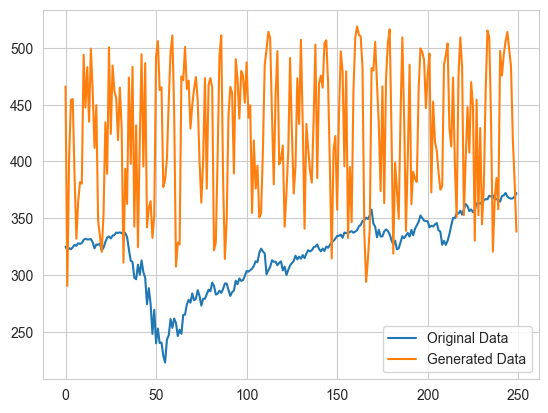

In [140]:
plt.plot(range(len(ori_data[0])), ori_data[0], label='Original Data')
plt.plot(range(len(generated_data[5])), generated_data[5], label='Generated Data')
plt.legend()
plt.show()